In [3]:
import tensorflow as tf
import numpy as np
import random
import math
import os

# Parameters
epsilon = 1  # The probability of choosing a random action (in training). This decays as iterations increase. (0 to 1)
epsilonMinimumValue = 0.001 # The minimum value we want epsilon to reach in training. (0 to 1)
nbActions = 3 # The number of actions. Since we only have left/stay/right that means 3 actions.
epoch = 1001 # The number of games we want the system to run for.
hiddenSize = 100 # Number of neurons in the hidden layers.
maxMemory = 500 # How large should the memory be (where it stores its past experiences).
batchSize = 50 # The mini-batch size for training. Samples are randomly taken from memory till mini-batch size.
gridSize = 10 # The size of the grid that the agent is going to play the game on.
nbStates = gridSize * gridSize # We eventually flatten to a 1d tensor to feed the network.
discount = 0.9 # The discount is used to force the network to choose states that lead to the reward quicker (0 to 1)
learningRate = 0.2 # Learning Rate for Stochastic Gradient Descent (our optimizer).
tf.compat.v1.disable_eager_execution()


# Create the base model.
X = tf.compat.v1.placeholder(tf.float32, [None, nbStates])
W1 = tf.Variable(tf.random.truncated_normal([nbStates, hiddenSize], stddev=1.0 / math.sqrt(float(nbStates))))
b1 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01))
input_layer = tf.nn.relu(tf.matmul(X, W1) + b1)
W2 = tf.Variable(tf.random.truncated_normal([hiddenSize, hiddenSize],stddev=1.0 / math.sqrt(float(hiddenSize))))
b2 = tf.Variable(tf.random.truncated_normal([hiddenSize], stddev=0.01))
hidden_layer = tf.nn.relu(tf.matmul(input_layer, W2) + b2)
W3 = tf.Variable(tf.random.truncated_normal([hiddenSize, nbActions],stddev=1.0 / math.sqrt(float(hiddenSize))))
b3 = tf.Variable(tf.random.truncated_normal([nbActions], stddev=0.01))
output_layer = tf.matmul(hidden_layer, W3) + b3

# True labels
Y = tf.compat.v1.placeholder(tf.float32, [None, nbActions])

# Mean squared error cost function
cost = tf.reduce_sum(input_tensor=tf.square(Y-output_layer)) / (2*batchSize)

# Stochastic Gradient Decent Optimizer
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learningRate).minimize(cost)


# Helper function: Chooses a random value between the two boundaries.
def randf(s, e):
  return (float(random.randrange(0, (e - s) * 9999)) / 10000) + s;


# The environment: Handles interactions and contains the state of the environment
class CatchEnvironment():
  def __init__(self, gridSize):
    self.gridSize = gridSize
    self.nbStates = self.gridSize * self.gridSize
    self.state = np.empty(3, dtype = np.uint8)

  # Returns the state of the environment.
  def observe(self):
    canvas = self.drawState()
    canvas = np.reshape(canvas, (-1,self.nbStates))
    return canvas

  def drawState(self):
    canvas = np.zeros((self.gridSize, self.gridSize))
    canvas[self.state[0]-1, self.state[1]-1] = 1  # Draw the fruit.
    # Draw the basket. The basket takes the adjacent two places to the position of basket.
    canvas[self.gridSize-1, self.state[2] -1 - 1] = 1
    canvas[self.gridSize-1, self.state[2] -1] = 1
    canvas[self.gridSize-1, self.state[2] -1 + 1] = 1
    return canvas

  # Resets the environment. Randomly initialise the fruit position (always at the top to begin with) and bucket.
  def reset(self):
    initialFruitColumn = random.randrange(1, self.gridSize + 1)
    initialBucketPosition = random.randrange(2, self.gridSize + 1 - 1)
    self.state = np.array([1, initialFruitColumn, initialBucketPosition])
    return self.getState()

  def getState(self):
    stateInfo = self.state
    fruit_row = stateInfo[0]
    fruit_col = stateInfo[1]
    basket = stateInfo[2]
    return fruit_row, fruit_col, basket

  # Returns the award that the agent has gained for being in the current environment state.
  def getReward(self):
    fruitRow, fruitColumn, basket = self.getState()
    if (fruitRow == self.gridSize - 1):  # If the fruit has reached the bottom.
      if (abs(fruitColumn - basket) <= 1): # Check if the basket caught the fruit.
        return 1
      else:
        return -1
    else:
      return 0

  def isGameOver(self):
    if (self.state[0] == self.gridSize - 1):
      return True
    else:
      return False

  def updateState(self, action):
    if (action == 1):
      action = -1
    elif (action == 2):
      action = 0
    else:
      action = 1
    fruitRow, fruitColumn, basket = self.getState()
    newBasket = min(max(2, basket + action), self.gridSize - 1) # The min/max prevents the basket from moving out of the grid.
    fruitRow = fruitRow + 1  # The fruit is falling by 1 every action.
    self.state = np.array([fruitRow, fruitColumn, newBasket])

  #Action can be 1 (move left) or 2 (move right)
  def act(self, action):
    self.updateState(action)
    reward = self.getReward()
    gameOver = self.isGameOver()
    return self.observe(), reward, gameOver, self.getState()   # For purpose of the visual, I also return the state.


# The memory: Handles the internal memory that we add experiences that occur based on agent's actions,
# and creates batches of experiences based on the mini-batch size for training.
class ReplayMemory:
  def __init__(self, gridSize, maxMemory, discount):
    self.maxMemory = maxMemory
    self.gridSize = gridSize
    self.nbStates = self.gridSize * self.gridSize
    self.discount = discount
    canvas = np.zeros((self.gridSize, self.gridSize))
    canvas = np.reshape(canvas, (-1,self.nbStates))
    self.inputState = np.empty((self.maxMemory, 100), dtype = np.float32)
    self.actions = np.zeros(self.maxMemory, dtype = np.uint8)
    self.nextState = np.empty((self.maxMemory, 100), dtype = np.float32)
    self.gameOver = np.empty(self.maxMemory, dtype = np.bool)
    self.rewards = np.empty(self.maxMemory, dtype = np.int8)
    self.count = 0
    self.current = 0

  # Appends the experience to the memory.
  def remember(self, currentState, action, reward, nextState, gameOver):
    self.actions[self.current] = action
    self.rewards[self.current] = reward
    self.inputState[self.current, ...] = currentState
    self.nextState[self.current, ...] = nextState
    self.gameOver[self.current] = gameOver
    self.count = max(self.count, self.current + 1)
    self.current = (self.current + 1) % self.maxMemory

  def getBatch(self, model, batchSize, nbActions, nbStates, sess, X):

    # We check to see if we have enough memory inputs to make an entire batch, if not we create the biggest
    # batch we can (at the beginning of training we will not have enough experience to fill a batch).
    memoryLength = self.count
    chosenBatchSize = min(batchSize, memoryLength)

    inputs = np.zeros((chosenBatchSize, nbStates))
    targets = np.zeros((chosenBatchSize, nbActions))

    # Fill the inputs and targets up.
    for i in range(chosenBatchSize):
      if memoryLength == 1:
        memoryLength = 2
      # Choose a random memory experience to add to the batch.
      randomIndex = random.randrange(1, memoryLength)
      current_inputState = np.reshape(self.inputState[randomIndex], (1, 100))

      target = sess.run(model, feed_dict={X: current_inputState})

      current_nextState =  np.reshape(self.nextState[randomIndex], (1, 100))
      current_outputs = sess.run(model, feed_dict={X: current_nextState})

      # Gives us Q_sa, the max q for the next state.
      nextStateMaxQ = np.amax(current_outputs)
      if (self.gameOver[randomIndex] == True):
        target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex]
      else:
        # reward + discount(gamma) * max_a' Q(s',a')
        # We are setting the Q-value for the action to  r + gamma*max a' Q(s', a'). The rest stay the same
        # to give an error of 0 for those outputs.
        target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex] + self.discount * nextStateMaxQ

      # Update the inputs and targets.
      inputs[i] = current_inputState
      targets[i] = target

    return inputs, targets


def main(_):
  print("Training new model")

  # Define Environment
  env = CatchEnvironment(gridSize)

  # Define Replay Memory
  memory = ReplayMemory(gridSize, maxMemory, discount)

  # Add ops to save and restore all the variables.
  saver = tf.compat.v1.train.Saver()

  winCount = 0
  with tf.compat.v1.Session() as sess:
    tf.compat.v1.initialize_all_variables().run()

    for i in range(epoch):
      # Initialize the environment.
      err = 0
      env.reset()

      isGameOver = False

      # The initial state of the environment.
      currentState = env.observe()

      while (isGameOver != True):
        action = -9999  # action initilization
        # Decides if we should choose a random action, or an action from the policy network.
        global epsilon
        if (randf(0, 1) <= epsilon):
          action = random.randrange(1, nbActions+1)
        else:
          # Forward the current state through the network.
          q = sess.run(output_layer, feed_dict={X: currentState})
          # Find the max index (the chosen action).
          index = q.argmax()
          action = index + 1

        # Decay the epsilon by multiplying by 0.999, not allowing it to go below a certain threshold.
        if (epsilon > epsilonMinimumValue):
          epsilon = epsilon * 0.999

        nextState, reward, gameOver, stateInfo = env.act(action)

        if (reward == 1):
          winCount = winCount + 1

        memory.remember(currentState, action, reward, nextState, gameOver)

        # Update the current state and if the game is over.
        currentState = nextState
        isGameOver = gameOver

        # We get a batch of training data to train the model.
        inputs, targets = memory.getBatch(output_layer, batchSize, nbActions, nbStates, sess, X)

        # Train the network which returns the error.
        _, loss = sess.run([optimizer, cost], feed_dict={X: inputs, Y: targets})
        err = err + loss

      print("Epoch " + str(i) + ": err = " + str(err) + ": Win count = " + str(winCount) + " Win ratio = " + str(float(winCount)/float(i+1)*100))
    # Save the variables to disk.
    save_path = saver.save(sess, os.getcwd()+"/model.ckpt")
    print("Model saved in file: %s" % save_path)

if __name__ == '__main__':
  tf.compat.v1.app.run()

Training new model
Epoch 0: err = nan: Win count = 0 Win ratio = 0.0
Epoch 1: err = nan: Win count = 0 Win ratio = 0.0
Epoch 2: err = nan: Win count = 0 Win ratio = 0.0
Epoch 3: err = nan: Win count = 0 Win ratio = 0.0
Epoch 4: err = nan: Win count = 0 Win ratio = 0.0
Epoch 5: err = nan: Win count = 1 Win ratio = 16.666666666666664
Epoch 6: err = nan: Win count = 2 Win ratio = 28.57142857142857
Epoch 7: err = nan: Win count = 3 Win ratio = 37.5
Epoch 8: err = nan: Win count = 4 Win ratio = 44.44444444444444
Epoch 9: err = nan: Win count = 4 Win ratio = 40.0
Epoch 10: err = nan: Win count = 4 Win ratio = 36.36363636363637
Epoch 11: err = nan: Win count = 4 Win ratio = 33.33333333333333
Epoch 12: err = nan: Win count = 4 Win ratio = 30.76923076923077
Epoch 13: err = nan: Win count = 5 Win ratio = 35.714285714285715
Epoch 14: err = nan: Win count = 6 Win ratio = 40.0
Epoch 15: err = nan: Win count = 7 Win ratio = 43.75
Epoch 16: err = nan: Win count = 8 Win ratio = 47.05882352941176
Epoch

Epoch 129: err = nan: Win count = 45 Win ratio = 34.61538461538461
Epoch 130: err = nan: Win count = 45 Win ratio = 34.35114503816794
Epoch 131: err = nan: Win count = 45 Win ratio = 34.090909090909086
Epoch 132: err = nan: Win count = 46 Win ratio = 34.58646616541353
Epoch 133: err = nan: Win count = 46 Win ratio = 34.32835820895522
Epoch 134: err = nan: Win count = 46 Win ratio = 34.074074074074076
Epoch 135: err = nan: Win count = 46 Win ratio = 33.82352941176471
Epoch 136: err = nan: Win count = 47 Win ratio = 34.306569343065696
Epoch 137: err = nan: Win count = 47 Win ratio = 34.05797101449276
Epoch 138: err = nan: Win count = 48 Win ratio = 34.53237410071942
Epoch 139: err = nan: Win count = 48 Win ratio = 34.285714285714285
Epoch 140: err = nan: Win count = 49 Win ratio = 34.751773049645394
Epoch 141: err = nan: Win count = 49 Win ratio = 34.50704225352113
Epoch 142: err = nan: Win count = 50 Win ratio = 34.96503496503497
Epoch 143: err = nan: Win count = 50 Win ratio = 34.72222

Epoch 252: err = nan: Win count = 80 Win ratio = 31.620553359683797
Epoch 253: err = nan: Win count = 81 Win ratio = 31.88976377952756
Epoch 254: err = nan: Win count = 81 Win ratio = 31.76470588235294
Epoch 255: err = nan: Win count = 81 Win ratio = 31.640625
Epoch 256: err = nan: Win count = 81 Win ratio = 31.517509727626457
Epoch 257: err = nan: Win count = 82 Win ratio = 31.782945736434108
Epoch 258: err = nan: Win count = 83 Win ratio = 32.04633204633205
Epoch 259: err = nan: Win count = 83 Win ratio = 31.92307692307692
Epoch 260: err = nan: Win count = 83 Win ratio = 31.800766283524908
Epoch 261: err = nan: Win count = 84 Win ratio = 32.06106870229007
Epoch 262: err = nan: Win count = 84 Win ratio = 31.93916349809886
Epoch 263: err = nan: Win count = 85 Win ratio = 32.196969696969695
Epoch 264: err = nan: Win count = 86 Win ratio = 32.45283018867924
Epoch 265: err = nan: Win count = 87 Win ratio = 32.70676691729324
Epoch 266: err = nan: Win count = 88 Win ratio = 32.9588014981273

Epoch 373: err = nan: Win count = 108 Win ratio = 28.87700534759358
Epoch 374: err = nan: Win count = 108 Win ratio = 28.799999999999997
Epoch 375: err = nan: Win count = 109 Win ratio = 28.98936170212766
Epoch 376: err = nan: Win count = 109 Win ratio = 28.912466843501328
Epoch 377: err = nan: Win count = 109 Win ratio = 28.835978835978835
Epoch 378: err = nan: Win count = 110 Win ratio = 29.023746701846964
Epoch 379: err = nan: Win count = 111 Win ratio = 29.210526315789476
Epoch 380: err = nan: Win count = 111 Win ratio = 29.133858267716533
Epoch 381: err = nan: Win count = 111 Win ratio = 29.05759162303665
Epoch 382: err = nan: Win count = 111 Win ratio = 28.98172323759791
Epoch 383: err = nan: Win count = 111 Win ratio = 28.90625
Epoch 384: err = nan: Win count = 111 Win ratio = 28.83116883116883
Epoch 385: err = nan: Win count = 111 Win ratio = 28.756476683937827
Epoch 386: err = nan: Win count = 112 Win ratio = 28.940568475452196
Epoch 387: err = nan: Win count = 113 Win ratio =

Epoch 494: err = nan: Win count = 149 Win ratio = 30.1010101010101
Epoch 495: err = nan: Win count = 149 Win ratio = 30.040322580645164
Epoch 496: err = nan: Win count = 150 Win ratio = 30.181086519114686
Epoch 497: err = nan: Win count = 150 Win ratio = 30.120481927710845
Epoch 498: err = nan: Win count = 150 Win ratio = 30.060120240480963
Epoch 499: err = nan: Win count = 150 Win ratio = 30.0
Epoch 500: err = nan: Win count = 150 Win ratio = 29.94011976047904
Epoch 501: err = nan: Win count = 151 Win ratio = 30.0796812749004
Epoch 502: err = nan: Win count = 151 Win ratio = 30.019880715705767
Epoch 503: err = nan: Win count = 152 Win ratio = 30.158730158730158
Epoch 504: err = nan: Win count = 153 Win ratio = 30.297029702970296
Epoch 505: err = nan: Win count = 154 Win ratio = 30.434782608695656
Epoch 506: err = nan: Win count = 155 Win ratio = 30.57199211045365
Epoch 507: err = nan: Win count = 156 Win ratio = 30.708661417322837
Epoch 508: err = nan: Win count = 157 Win ratio = 30.8

Epoch 733: err = nan: Win count = 227 Win ratio = 30.92643051771117
Epoch 734: err = nan: Win count = 228 Win ratio = 31.020408163265305
Epoch 735: err = nan: Win count = 229 Win ratio = 31.11413043478261
Epoch 736: err = nan: Win count = 229 Win ratio = 31.071913161465396
Epoch 737: err = nan: Win count = 230 Win ratio = 31.16531165311653
Epoch 738: err = nan: Win count = 231 Win ratio = 31.25845737483085
Epoch 739: err = nan: Win count = 231 Win ratio = 31.216216216216214
Epoch 740: err = nan: Win count = 231 Win ratio = 31.17408906882591
Epoch 741: err = nan: Win count = 231 Win ratio = 31.132075471698112
Epoch 742: err = nan: Win count = 231 Win ratio = 31.090174966352624
Epoch 743: err = nan: Win count = 231 Win ratio = 31.048387096774192
Epoch 744: err = nan: Win count = 231 Win ratio = 31.00671140939597
Epoch 745: err = nan: Win count = 231 Win ratio = 30.96514745308311
Epoch 746: err = nan: Win count = 231 Win ratio = 30.923694779116467
Epoch 747: err = nan: Win count = 231 Win

Epoch 853: err = nan: Win count = 271 Win ratio = 31.733021077283375
Epoch 854: err = nan: Win count = 271 Win ratio = 31.69590643274854
Epoch 855: err = nan: Win count = 271 Win ratio = 31.6588785046729
Epoch 856: err = nan: Win count = 272 Win ratio = 31.738623103850642
Epoch 857: err = nan: Win count = 272 Win ratio = 31.7016317016317
Epoch 858: err = nan: Win count = 272 Win ratio = 31.664726426076832
Epoch 859: err = nan: Win count = 272 Win ratio = 31.627906976744185
Epoch 860: err = nan: Win count = 272 Win ratio = 31.59117305458769
Epoch 861: err = nan: Win count = 272 Win ratio = 31.554524361948953
Epoch 862: err = nan: Win count = 273 Win ratio = 31.63383545770568
Epoch 863: err = nan: Win count = 273 Win ratio = 31.59722222222222
Epoch 864: err = nan: Win count = 273 Win ratio = 31.5606936416185
Epoch 865: err = nan: Win count = 273 Win ratio = 31.524249422632796
Epoch 866: err = nan: Win count = 274 Win ratio = 31.603229527104958
Epoch 867: err = nan: Win count = 275 Win ra

Epoch 973: err = nan: Win count = 310 Win ratio = 31.82751540041068
Epoch 974: err = nan: Win count = 310 Win ratio = 31.794871794871792
Epoch 975: err = nan: Win count = 310 Win ratio = 31.762295081967213
Epoch 976: err = nan: Win count = 310 Win ratio = 31.72978505629478
Epoch 977: err = nan: Win count = 310 Win ratio = 31.697341513292432
Epoch 978: err = nan: Win count = 310 Win ratio = 31.66496424923391
Epoch 979: err = nan: Win count = 310 Win ratio = 31.63265306122449
Epoch 980: err = nan: Win count = 310 Win ratio = 31.60040774719674
Epoch 981: err = nan: Win count = 311 Win ratio = 31.67006109979633
Epoch 982: err = nan: Win count = 311 Win ratio = 31.637843336724313
Epoch 983: err = nan: Win count = 311 Win ratio = 31.60569105691057
Epoch 984: err = nan: Win count = 312 Win ratio = 31.6751269035533
Epoch 985: err = nan: Win count = 312 Win ratio = 31.643002028397564
Epoch 986: err = nan: Win count = 312 Win ratio = 31.61094224924012
Epoch 987: err = nan: Win count = 312 Win ra

SystemExit: 

C:\anaconda\envs\gym\lib\site-packages\IPython\core\interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Using matplotlib backend: TkAgg


AttributeError: module 'tensorflow._api.v2.train' has no attribute 'Saver'

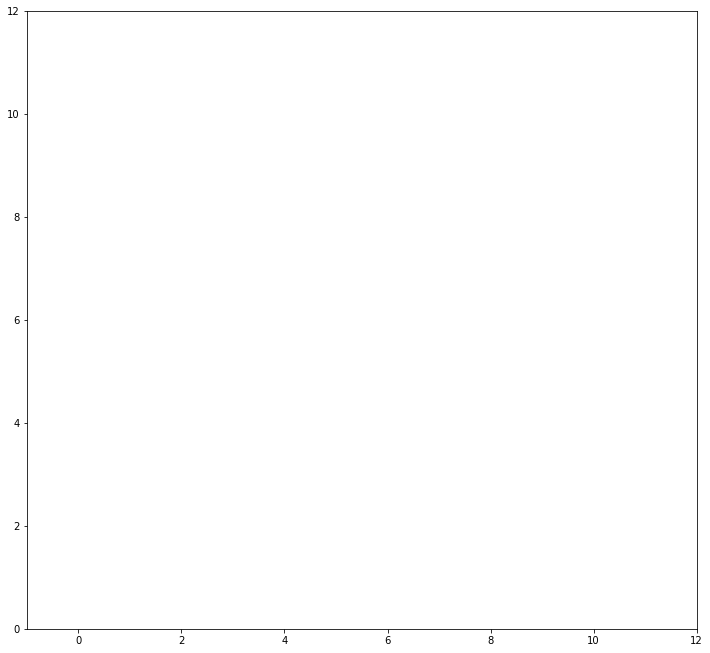